In [75]:
import os,glob
import numpy as np
import matplotlib.pyplot as plt
import helpers
from helpers import fb,pb,TeV,GeV,m,MeV,mm,fm
import matplotlib as mpl
import matplotlib.tri as tri
from collections import OrderedDict
import math

## Get HSCP efficiencies

In [2]:
#Get exclusion curve for 8 TeV (tracker)
# M1dataFile = '../smodels-database/8TeV/CMS/CMS-EXO-13-006-eff/orig/eff_HSCPM1_c000.txt'
# M2dataFile = '../smodels-database/8TeV/CMS/CMS-EXO-13-006-eff/orig/eff_HSCPM2_c000.txt'
M1dataFile = '../smodels-database/13TeV/CMS/CMS-PAS-EXO-16-036-eff/orig/effmap_M1_chargino_cons_mrec000_trim.txt'
M2dataFile = '../smodels-database/13TeV/CMS/CMS-PAS-EXO-16-036-eff/orig/effmap_M2_chargino_cons_mrec000_trim.txt'
e12Func = helpers.getUpperLimitFrom(M1dataFile,xcol=0,ycol=1,unit=1.,doLog=False)
e1Func = helpers.getUpperLimitFrom(M2dataFile,xcol=0,ycol=1,unit=1.,doLog=False)

## Get SLHA and fLLP data

In [95]:
slhaFiles = [f for f in glob.glob('./slha_zeroWidth/*up.slha')]
fractionFiles = [f for f in glob.glob('./LLPfraction_13TeV/*up.txt')]
# fractionFiles = [f for f in glob.glob('./LLPfraction_13TeV/*leptons.txt')]

# massPDG = widthPDG = 5000011
# xsecPDGs = (2212, 2212, -5000011, 5000011)
massPDG = widthPDG = 5000002
xsecPDGs = (2212, 2212, -5000002, 5000002)
# xsecSqrts = 8*TeV
xsecSqrts = 13*TeV
upperLimitFunction = lambda x: 1.*fb
slhaData = helpers.getData(slhaFiles,massPDG,widthPDG,xsecSqrts,xsecPDGs,upperLimitFunction)
for slhafile in slhaData:
    res = slhaData[slhafile]
    mass = res['mass (GeV)']
    e12 = e12Func(mass)
    e1 = e1Func(mass)
    slhaData[slhafile].update({'e12' : e12, 'e1' : e1})
fractionData = helpers.getLLPFractionData(fractionFiles,xcol=0,ycol=1)

In [96]:
#SModelS expr:
# sigma_eff = (e12*Flong**2 + 2*Flong*Fprompt*e1)*sigma
#Full expr:
# sigma_eff = e12*fLLP*sigma
#Solving for Flong:
#Flong = math.sqrt( (e1*Fprompt/e12)**2  + fLLP) - e1*Fprompt/e12

#        
#        Fprompt = 1. - math.exp(-width*l_inner/(gb_inner*hc))
#        Flong = math.exp(-width*l_outer/(gb_outer*hc))
#        gb_outer = -l_outer/(ctau*math.log(Flong))

l_inner=1e-3*m
gb_inner=1.3
l_outer=10.*m
gb_outer=1.3
points = []
for slhafile in slhaData:
    res = slhaData[slhafile]
    fLLP = fractionData[slhafile]
    e12 = res['e12']
    e1 = res['e1']
    if not e12 or not e1:
        continue
    ctau = l_outer.asNumber(m)/fLLP[:,0]
    Fprompt = 1. - np.exp(-l_inner.asNumber(m)/(gb_inner*ctau))
    Flong = np.sqrt((e1*Fprompt/e12)**2  + fLLP[:,1]) - e1*Fprompt/e12
    gb_outer = -l_outer.asNumber(m)/(ctau*np.log(Flong))    
    mList = [res['mass (GeV)']]*len(ctau)   
    points += zip(mList,ctau,gb_outer,fLLP[:,1],Flong)
points = np.array(points)

## Plot Results

('gb_max=', 2.372969188350355, 'gb_min=', 1.5089422992820416)


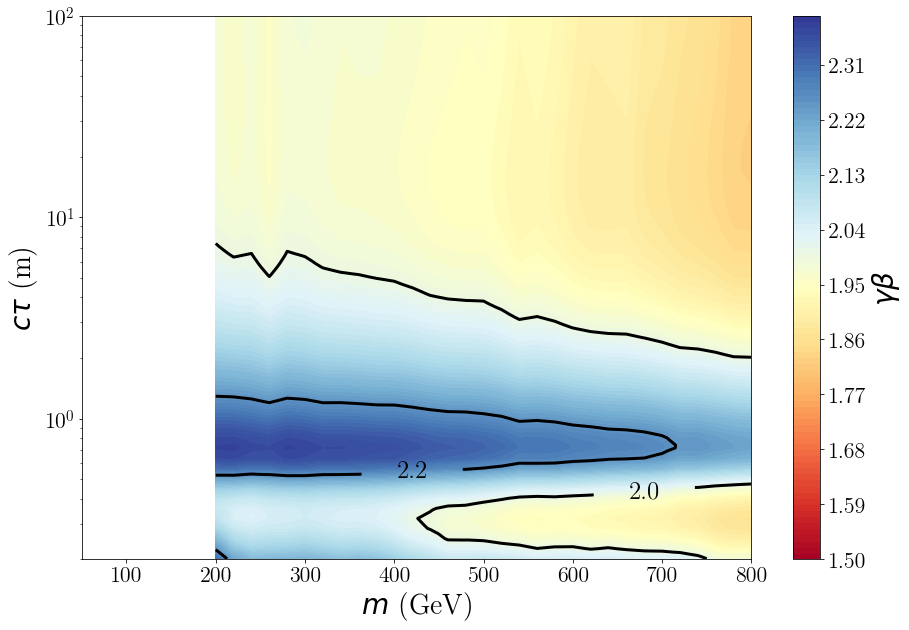

In [97]:
from commonRCparameters import params
mpl.rcParams.update(params)
cm = plt.cm.get_cmap('RdYlBu')
zmax = max([x for x in points[:,2] if not np.isnan(x)])
zmin = min([x for x in points[:,2] if not np.isnan(x)])
print('gb_max=',zmax,'gb_min=',zmin)

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(points[:,0], points[:,1])
z = points[:,2]
#Refine triangulation (for obtaining smoother curves)
# refiner = tri.UniformTriRefiner(triang)
# triang, z = refiner.refine_field(z, subdiv=3) #subdiv controls how many times we subdivide the data

# Plot scatter plot (for double checking the results)
# sc = plt.scatter(points[:,0], points[:,1], c=points[:,2], vmin=zmin, vmax=zmax, s=350, cmap=cm)
# OR plot contour plot:
cp = plt.tricontourf(triang, z,levels=np.arange(round(zmin,1),round(zmax,1),0.01),cmap=cm)
cb = plt.colorbar(cp)
cs = plt.tricontour(triang, z, colors='k',levels=np.arange(round(zmin,1),round(zmax,1),0.25))
plt.clabel(cs, cs.levels, inline=True, fontsize=25, fmt='%1.1f')
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$c\tau$ (m)')
cb.set_label(r'$\gamma \beta$')
plt.ylim(2e-1,1e2)
plt.xlim(50.,800.)
plt.savefig('gbPlot.pdf')
plt.show()

('Leff_max=', 6.6271586426850275, 'Leff_min=', 4.214129727892429)


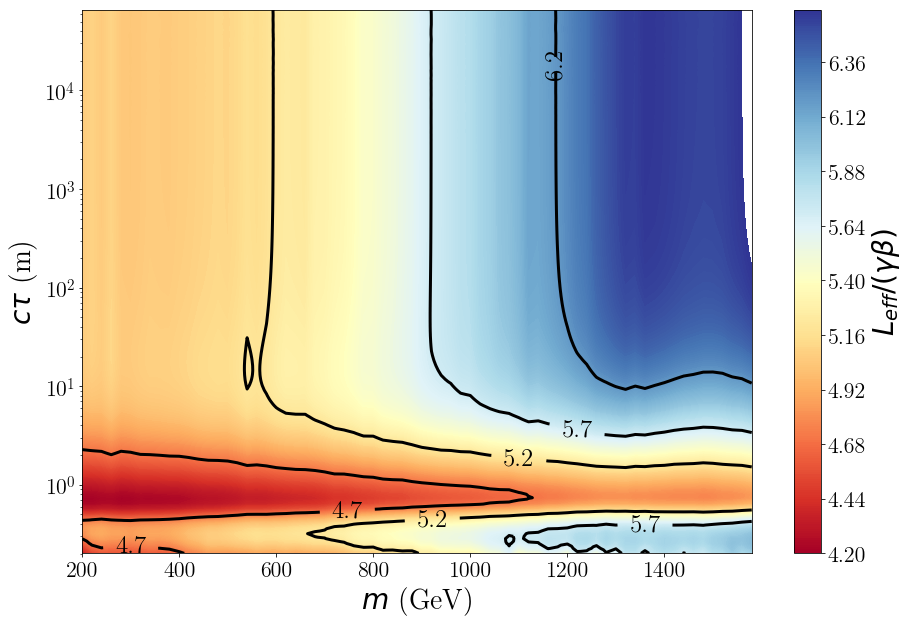

In [98]:
zmax = max([l_outer.asNumber(m)/x for x in points[:,2] if not np.isnan(x)])
zmin = min([l_outer.asNumber(m)/x for x in points[:,2] if not np.isnan(x)])
print('Leff_max=',zmax,'Leff_min=',zmin)

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(points[:,0], points[:,1])
z = l_outer.asNumber(m)/points[:,2]
#Refine triangulation (for obtaining smoother curves)
# refiner = tri.UniformTriRefiner(triang)
# triang, z = refiner.refine_field(z, subdiv=3) #subdiv controls how many times we subdivide the data

# Plot scatter plot (for double checking the results)
# sc = plt.scatter(points[:,0], points[:,1], c=points[:,2], vmin=zmin, vmax=zmax, s=350, cmap=cm)
# OR plot contour plot:
cp = plt.tricontourf(triang, z,levels=np.arange(round(zmin,1),round(zmax,1),0.01),cmap=cm)
cb = plt.colorbar(cp)
cs = plt.tricontour(triang, z, colors='k',levels=np.arange(round(zmin,1),round(zmax,1),0.5))
plt.clabel(cs, cs.levels, inline=True, fontsize=25, fmt='%1.1f')
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$c\tau$ (m)')
cb.set_label(r'$L_{eff}/(\gamma \beta)$')
# plt.ylim(2e-1,1e2)
# plt.xlim(50.,800.)
plt.savefig('Leff.pdf')
plt.show()